In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src import train, generate, eval
from src.train import make_inference_model
from src.pipeline_util import load_bnn
from src.modules.config import read_config
import src.modules.plots as plots
from src.modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json

In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test"

#BASE_DIR = "./tests/x-dim-test"
#PROFILE = "test"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

config["EPOCHS"] = "5"

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -2.445995590283073 - 2.2643438832509464
In Domain: (-10, 10)
Y-space: -2.292038921098926 - 2.1208595881462915
Out Domain: (-20, 20)
Y-space: -2.2153775188109868 - 2.4024802423086653


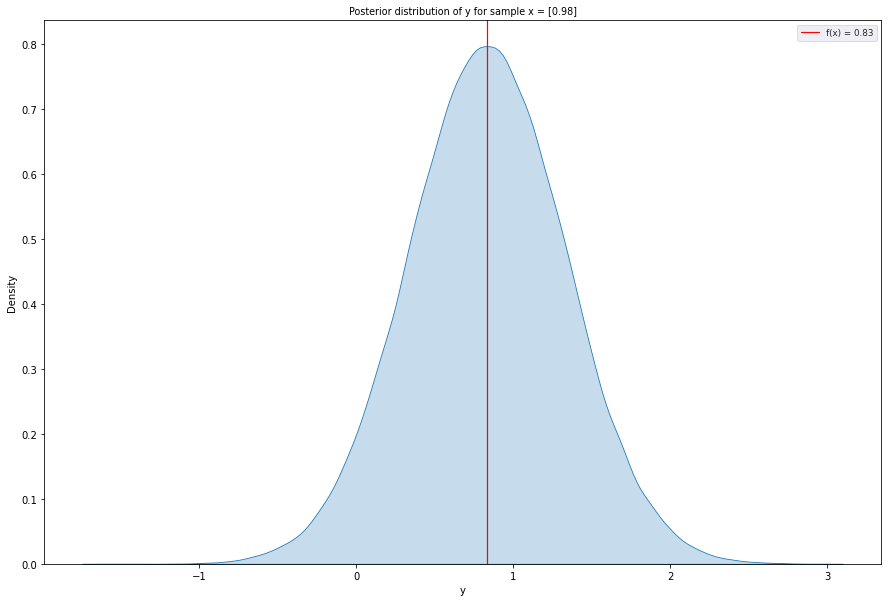

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [7]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


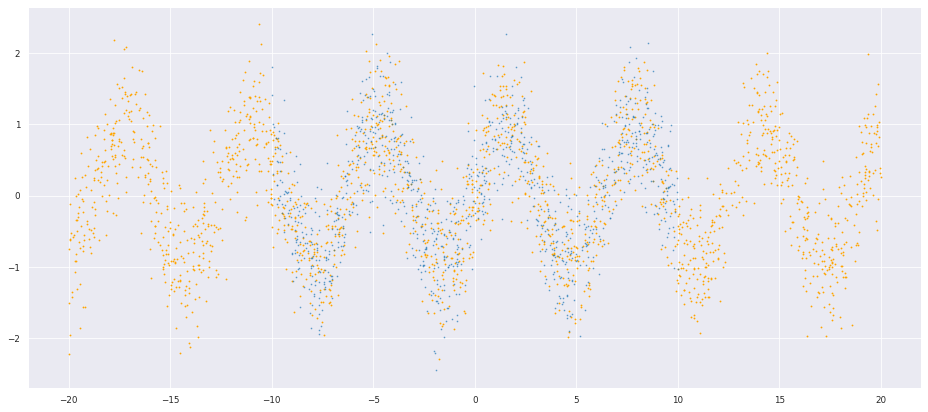

In [8]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [9]:
pyro.clear_param_store()

if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    train.train(config, dataset_config, f"{BASE_DIR}")

torch.Size([128, 1]) torch.Size([128, 1])
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Using device: cpu
===== Training profile tyxe-test - 1 =====
[0:00:00.072516] epoch: 0 | elbo: 6195.846008300781 | val_rmse: 2.544 | val_ll: -1.3286
(tensor(0.7173), tensor(0.0074))
Training finished in 0:00:01.433008 seconds
Saved SVI model to ../tests/sanity_check/models/tyxe-test/checkpoint_1.pt
File Size is 0.012873649597167969 MB


In [10]:
# import train stats
with open(f"{BASE_DIR}/results/{NAME}/train_stats.json", "r") as f:
    train_stats = json.load(f)
train_stats = train_stats[0]

Text(0.5, 1.0, 'LL')

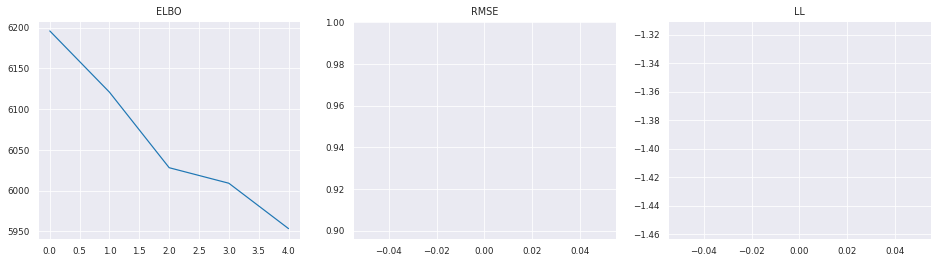

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(train_stats["elbos"])
ax[0].set_title("ELBO")
ax[1].plot(train_stats["rmse_epoch"])
ax[1].set_title("RMSE")
ax[2].plot(train_stats["ll_epoch"])
ax[2].set_title("LL")

In [12]:
bnn = make_inference_model(config, dataset_config)
bnn = load_bnn(bnn, "svi", f"{BASE_DIR}/models/{NAME}/checkpoint_1.pt")

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Loaded SVI model from ../tests/sanity_check/models/tyxe-test/checkpoint_1.pt


In [13]:
trace = poutine.trace(bnn.guide).get_trace(x_test_in_domain[0], y_test_in_domain[0])

In [14]:
trace.nodes.keys()

odict_keys(['_INPUT', 'net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'net_guide.net.2.0.weight.loc', 'net_guide.net.2.0.weight.scale', 'net_guide.net.2.0.bias.loc', 'net_guide.net.2.0.bias.scale', 'net_guide.net.3.weight.loc', 'net_guide.net.3.weight.scale', 'net_guide.net.3.bias.loc', 'net_guide.net.3.bias.scale', 'net.0.weight', 'net.0.bias', 'net.2.0.weight', 'net.2.0.bias', 'net.3.weight', 'net.3.bias', 'likelihood_guide.likelihood._scale.loc', 'likelihood_guide.likelihood._scale.scale', 'likelihood._scale', '_RETURN'])

In [15]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

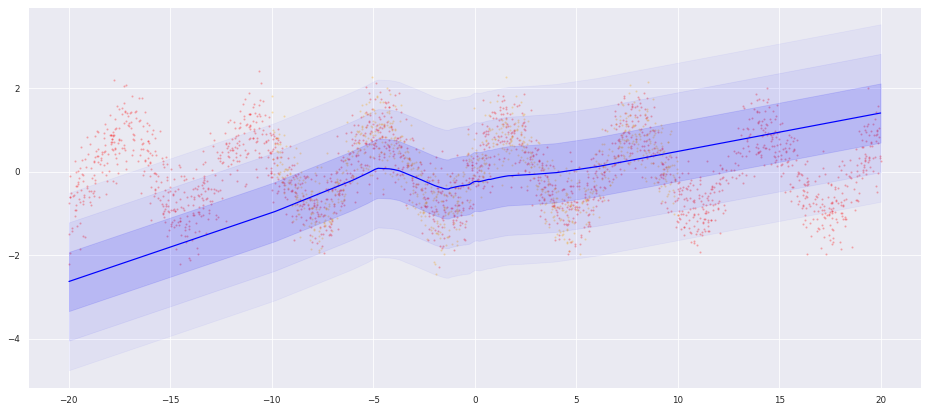

In [16]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

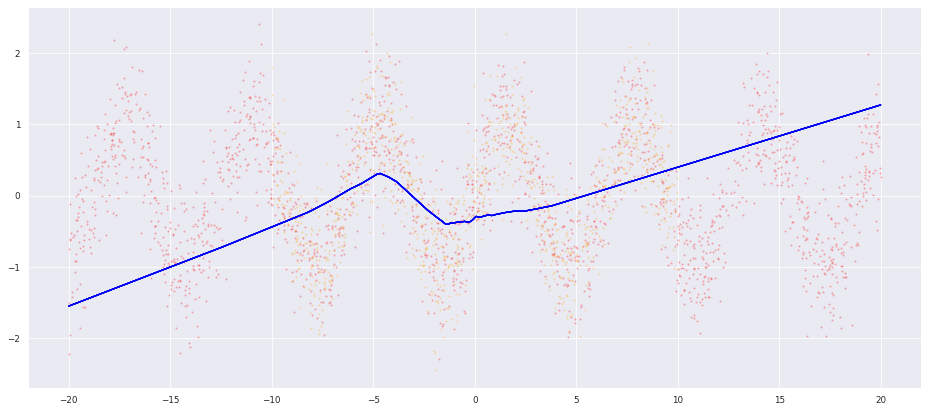

In [17]:
sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [18]:

if not os.path.exists(f"{BASE_DIR}/results"):
            os.mkdir(f"{BASE_DIR}/results")           
eval.eval(config, dataset_config, f"{BASE_DIR}", bnn=None)

data samples:  (1000, 1000)
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Loaded SVI model from ../tests/sanity_check/models/tyxe-test/checkpoint_1.pt
using device: cpu
====== evaluating profile tyxe-test - 1 ======
pred samples:  (1000, 1000)
Evaluating train...
Evaluating test...
Evaluating in_domain...
Evaluating out_domain...
Eval done in 0:00:22.551177


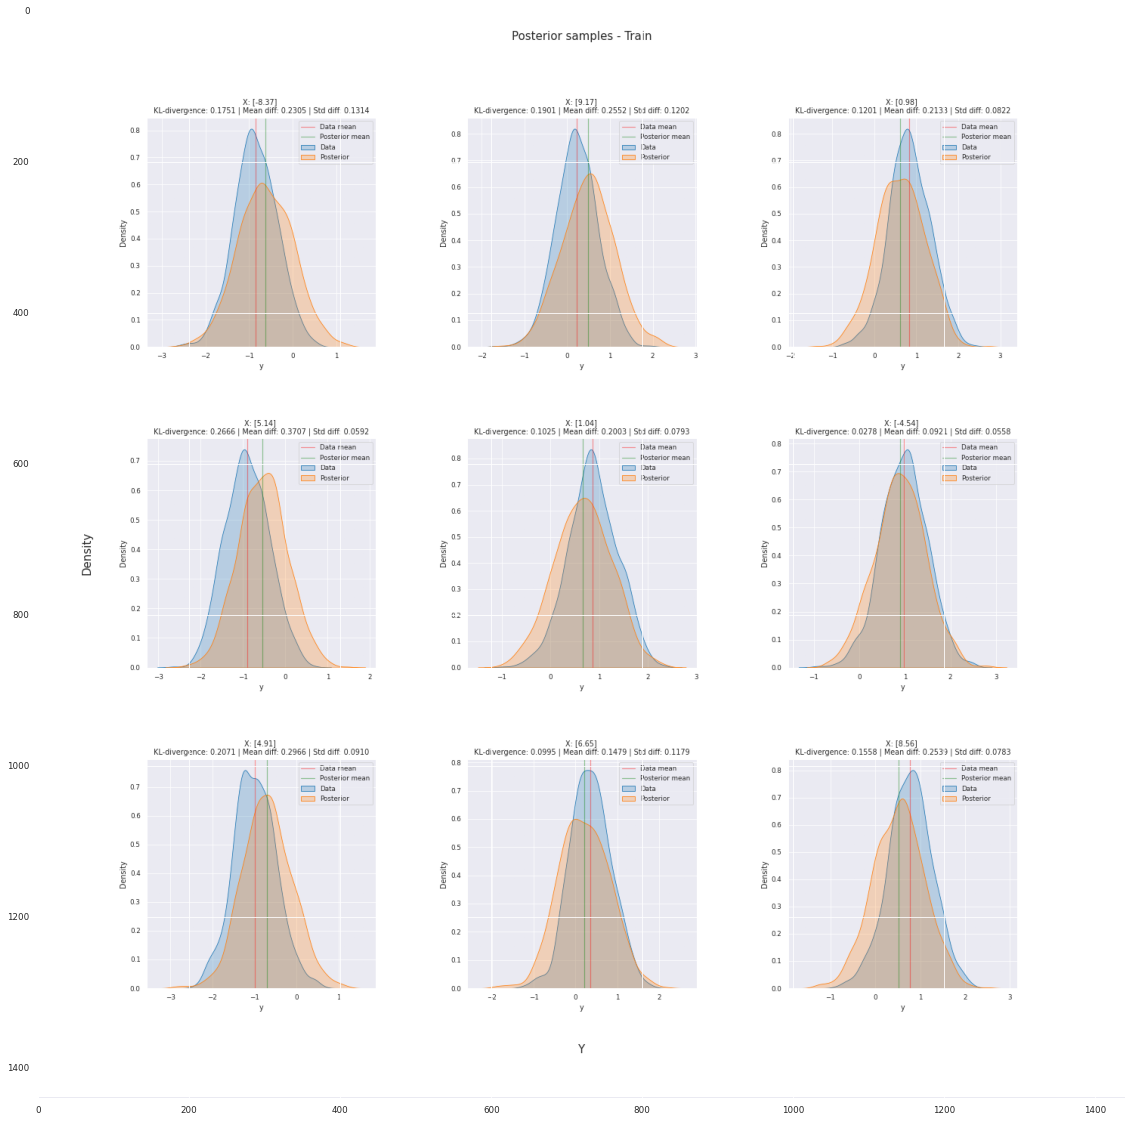

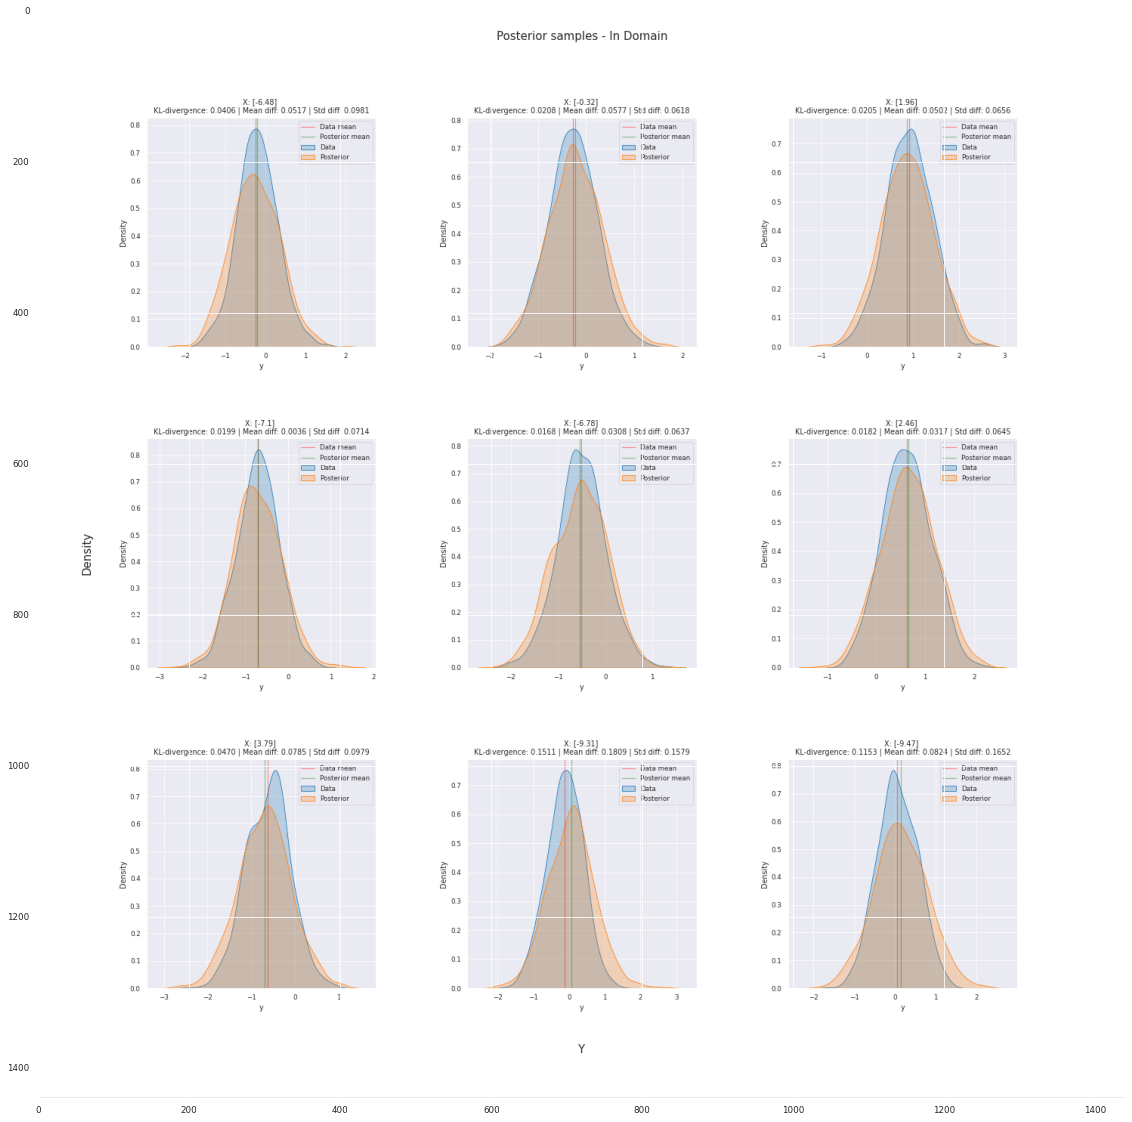

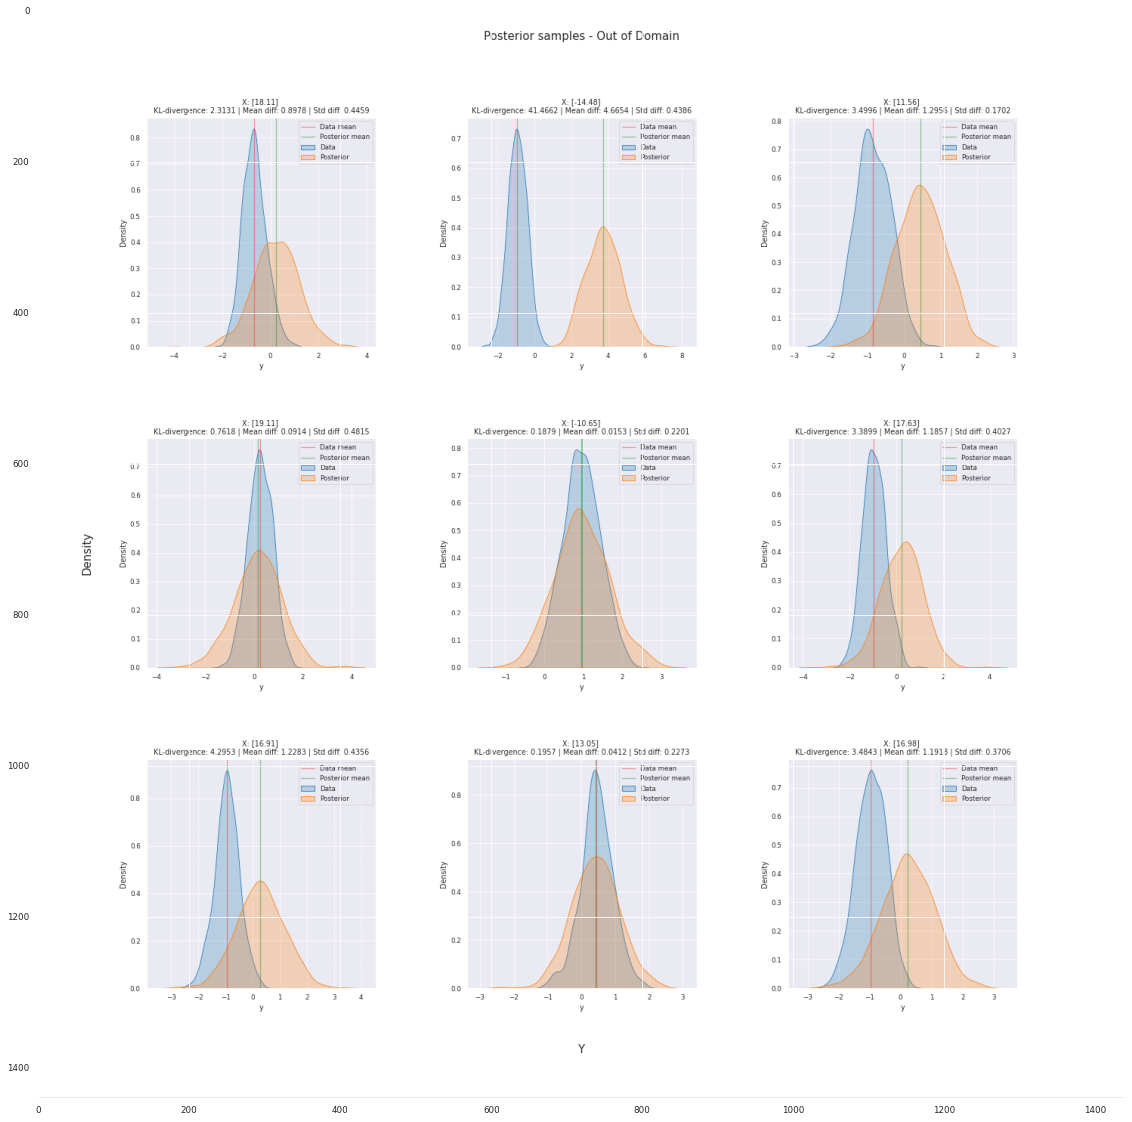

In [19]:
plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/train_sanity.png"))

plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/test_in_domain_sanity.png"))

plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/test_out_domain_sanity.png"))

In [21]:
file_stats = os.stat(f"{BASE_DIR}/models/{NAME}/checkpoint_1.pt")

print(file_stats)
print(f'File Size in Bytes is {file_stats.st_size}')
print(f'File Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

os.stat_result(st_mode=33188, st_ino=5805832, st_dev=66309, st_nlink=1, st_uid=1000, st_gid=1000, st_size=13499, st_atime=1686817442, st_mtime=1686817540, st_ctime=1686817540)
File Size in Bytes is 13499
File Size in MegaBytes is 0.012873649597167969
